In [25]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tqdm import tqdm
import contractions
import re
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
df = pd.read_csv(r'..\dataset\train-balanced-sarcasm.csv')
df.shape

(1010826, 10)

In [3]:
df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [4]:
#sort by createdd date 
df.sort_values(by='created_utc', inplace=True)
df.reset_index(drop=True, inplace=True)

Here I am sorting the dataset by created_utc, as some topics which are consider non-sarcastic today might be consider sarcastic later

In [5]:
df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,Rhetorical rheddit,veritaze,Marijuana,4,4,0,2009-01,2009-01-01 23:08:43,Why does the US Government support the use of ...
1,0,I was dreaming that I was a Snuffleupagus!,SleepingSheeple,WTF,3,3,0,2009-01,2009-01-01 23:50:50,And how much taxpayer money went into the Cook...
2,1,Obviously the most well-informed and unbiased ...,Tucci,reddit.com,0,0,0,2009-01,2009-01-02 07:03:22,"FTA: Ephraim Sneh, a former member of the Isra..."
3,1,Yes..wikipedia will teach it to you.,Kelevra,worldnews,7,7,0,2009-01,2009-01-02 07:28:56,Some redditors need to read the History of the...
4,0,Cheese.,McCourt,Art,2,2,0,2009-01,2009-01-02 15:28:00,Abstract beauty


In [6]:
#dropping nan values 
df.dropna(inplace=True)

In [7]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True, stratify=df['label'])
X_train, X_val = train_test_split(X_train, test_size=0.1, random_state=42, shuffle=True, stratify=X_train['label'])
X_train.shape, X_val.shape, X_test.shape

((727756, 10), (80862, 10), (202155, 10))

In [8]:
#coverting string to lowercase 
def string_lower(x):
    for i in ['comment','author','subreddit','parent_comment']:
        x[i] = x[i].str.lower()
    return x

X_train = string_lower(X_train)
X_val = string_lower(X_val)
X_test = string_lower(X_test)

In [9]:
X_train.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
34831,0,"it may be taken from ian dury's ""spasticus aut...",vladtheimpala,britishtv,5,5,0,2012-08,2012-08-22 01:41:48,yeah i just tried to forget about the name. al...
198489,0,"raiper running attack, i would restore it to i...",joelxivi,darksouls2,5,5,0,2014-09,2014-09-21 20:15:12,if you could change a single move of a weapon'...
273022,0,"why do you have such an expensive aug skin, bu...",glassofgum,globaloffensive,1,1,0,2015-02,2015-02-09 20:34:32,cheap skins that look nice? i am new to counte...
93500,1,"well that's ok, because we know for a fact tha...",rassimoflom,unitedkingdom,2,2,0,2013-10,2013-10-14 16:19:15,police chiefs will be able to be directly recr...
350017,1,"yeah, more climate change deniers in congress ...",hominid77777,pics,-1,-1,0,2015-06,2015-06-01 19:46:33,more of these guys in the gop would make gover...


In [10]:
#Checking label distribution
X_train['label'].value_counts(), X_val['label'].value_counts(), X_test['label'].value_counts()  

(0    363891
 1    363865
 Name: label, dtype: int64,
 0    40433
 1    40429
 Name: label, dtype: int64,
 0    101081
 1    101074
 Name: label, dtype: int64)

In [11]:
#preprocess textual data
def remove_contractions(x):
    output = []
    for i in x.split(' '):
        output.append(contractions.fix(i))
    output = ' '.join(output)
    #remove newline 
    output = re.sub(r'\n', ' ', output)
    # put spaces before & after punctuations to make words seprate. Like "king?" to "king", "?"
    #code link - https://www.kaggle.com/code/prashantkikani/are-you-being-sarcastic-sarcasm-detection-nlp
    output = re.sub(r"([?!,+=—&%\'\";:¿।।।|\(\){}\[\]//])", r" \1 ", output)
    # Remove more than 2 continues spaces with 1 space.
    output = re.sub('[ ]{2,}', ' ', output).strip()
    return output

def remove_contractions_df(x):
    for i in ['comment','parent_comment']:
        x[i] = x[i].apply(remove_contractions)
    return x

X_train = remove_contractions_df(X_train)
X_val = remove_contractions_df(X_val)
X_test = remove_contractions_df(X_test)

In [12]:
X_train.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
34831,0,"it may be taken from ian dury ' s "" spasticus ...",vladtheimpala,britishtv,5,5,0,2012-08,2012-08-22 01:41:48,yeah i just tried to forget about the name. al...
198489,0,"raiper running attack , i would restore it to ...",joelxivi,darksouls2,5,5,0,2014-09,2014-09-21 20:15:12,if you could change a single move of a weapon ...
273022,0,"why do you have such an expensive aug skin , b...",glassofgum,globaloffensive,1,1,0,2015-02,2015-02-09 20:34:32,cheap skins that look nice ? i am new to count...
93500,1,"well that is ok , because we know for a fact t...",rassimoflom,unitedkingdom,2,2,0,2013-10,2013-10-14 16:19:15,police chiefs will be able to be directly recr...
350017,1,"yeah , more climate change deniers in congress...",hominid77777,pics,-1,-1,0,2015-06,2015-06-01 19:46:33,more of these guys in the gop would make gover...


In [13]:
class CFG:
    VOCAB_SIZE = 50000
    MAX_LEN = 40
    EMBEDDING_DIM = 300
    BATCH_SIZE = 1024
    EPOCHS = 10
    LOSS = 'binary_crossentropy'
    OPTIMIZER = 'adam'


In [14]:
#Tokenizing the data
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=CFG.VOCAB_SIZE, oov_token='<unk>')
tokenizer.fit_on_texts(X_train['comment'])

train_data = tokenizer.texts_to_sequences(X_train['comment'])
train_data = tf.keras.preprocessing.sequence.pad_sequences(train_data, maxlen=CFG.MAX_LEN)

val_data = tokenizer.texts_to_sequences(X_val['comment'])
val_data = tf.keras.preprocessing.sequence.pad_sequences(val_data, maxlen=CFG.MAX_LEN)

test_data = tokenizer.texts_to_sequences(X_test['comment'])
test_data = tf.keras.preprocessing.sequence.pad_sequences(test_data, maxlen=CFG.MAX_LEN)

In [15]:
word_index = tokenizer.word_index

In [16]:
embeddings_index = {}
with open('..\\pretrained_models\\glove.840B.300d.txt', encoding='utf-8') as f:
    for line in tqdm(f):
        values = line.split(' ')
        word = values[0]
        coords = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coords
print('Found %s word vectors.' % len(embeddings_index))

2196017it [02:17, 15996.92it/s]

Found 2196016 word vectors.


In [17]:
embedding_matrix = np.zeros((len(word_index) + 1, CFG.EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [18]:
input_layer = Input(shape=(CFG.MAX_LEN,))
embedding_layer = Embedding(input_dim=len(word_index)+1,
                            output_dim=CFG.EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=CFG.MAX_LEN,
                            trainable=False)(input_layer)
lstm_layer = LSTM(100,name='LSTM')(embedding_layer)
dropout_layer = Dropout(0.2)(lstm_layer)
dense_layer_1 = Dense(units=256, activation='sigmoid')(dropout_layer)
dense_layer_2 = Dense(units=128, activation='sigmoid')(dropout_layer)
output_layer = Dense(units=1, activation='sigmoid')(dense_layer_2)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss=CFG.LOSS, optimizer=CFG.OPTIMIZER, metrics=['accuracy'])

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40)]              0         
                                                                 
 embedding (Embedding)       (None, 40, 300)           41777700  
                                                                 
 LSTM (LSTM)                 (None, 100)               160400    
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               12928     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 41,951,157
Trainable params: 173,457
Non-traina

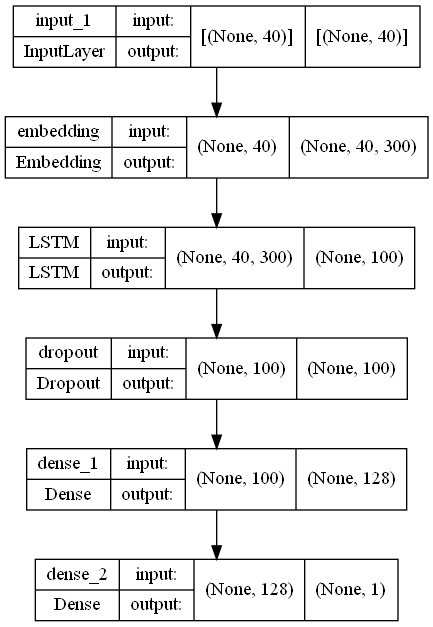

In [20]:
#plot the model
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [21]:
try:
    history = model.fit(train_data, X_train['label'], batch_size=CFG.BATCH_SIZE, epochs=CFG.EPOCHS, validation_data=(val_data, X_val['label']))
except KeyboardInterrupt:
    print('\nTraining stopped by user.')

Epoch 1/10
711/711 [==============================] - 35s 47ms/step - loss: 0.5901 - accuracy: 0.6798 - val_loss: 0.5577 - val_accuracy: 0.7111
Epoch 2/10
711/711 [==============================] - 33s 47ms/step - loss: 0.5500 - accuracy: 0.7158 - val_loss: 0.5410 - val_accuracy: 0.7232
Epoch 3/10
711/711 [==============================] - 33s 47ms/step - loss: 0.5360 - accuracy: 0.7270 - val_loss: 0.5331 - val_accuracy: 0.7282
Epoch 4/10
711/711 [==============================] - 33s 47ms/step - loss: 0.5269 - accuracy: 0.7337 - val_loss: 0.5332 - val_accuracy: 0.7274
Epoch 5/10
711/711 [==============================] - 34s 47ms/step - loss: 0.5195 - accuracy: 0.7390 - val_loss: 0.5245 - val_accuracy: 0.7356
Epoch 6/10
711/711 [==============================] - 34s 47ms/step - loss: 0.5130 - accuracy: 0.7437 - val_loss: 0.5256 - val_accuracy: 0.7338
Epoch 7/10
711/711 [==============================] - 34s 47ms/step - loss: 0.5068 - accuracy: 0.7481 - val_loss: 0.5223 - val_accuracy:

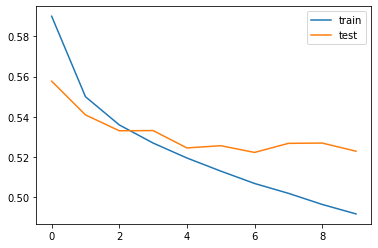

In [22]:
#plot loss and accuracy
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

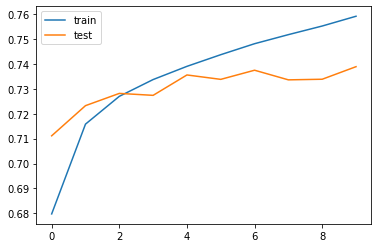

In [23]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [31]:
result = model.evaluate(test_data, X_test['label'])
print('Test set loss: ', result[0])
print('Test set accuracy: ', result[1])

6318/6318 [==============================] - 21s 3ms/step - loss: 0.5238 - accuracy: 0.7377
Test set loss:  0.5237764120101929
Test set accuracy:  0.737666666507721


In [27]:
pred = model.predict(test_data)
pred = np.where(pred > 0.5, 1, 0)
pred = np.array(pred, dtype=int).tolist()
ytrue = X_test['label'].tolist()

In [28]:
confusion_matrix(ytrue, pred)

array([[78979, 22102],
       [30930, 70144]], dtype=int64)

<AxesSubplot:>

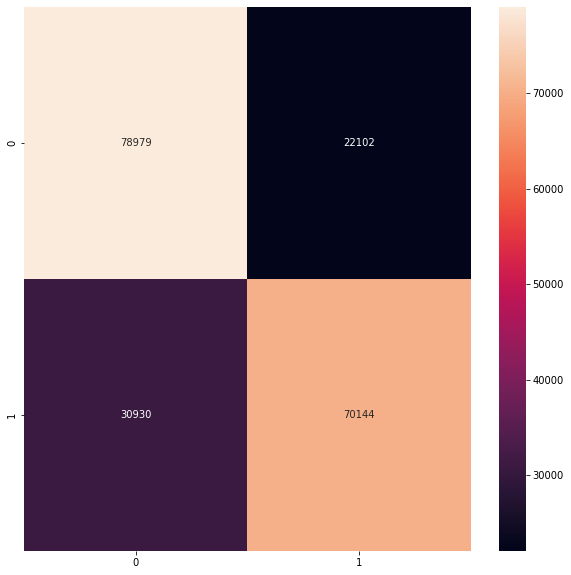

In [29]:
#plot the confusion matrix
import seaborn as sns
plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix(ytrue, pred), annot=True, fmt='d')

In [30]:
#classification report
print(classification_report(ytrue, pred))

              precision    recall  f1-score   support

           0       0.72      0.78      0.75    101081
           1       0.76      0.69      0.73    101074

    accuracy                           0.74    202155
   macro avg       0.74      0.74      0.74    202155
weighted avg       0.74      0.74      0.74    202155



### FastText Embedding

In [32]:
ft_path = r"..\pretrained_models\crawl-300d-2M.vec"

def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in tqdm(open(ft_path,'r',encoding='utf-8')))
word_index = tokenizer.word_index

1999996it [02:14, 14914.22it/s]


In [33]:
embedding_matrix = np.zeros((len(word_index) + 1, CFG.EMBEDDING_DIM))
for word, i in tqdm(word_index.items()):
    if i >= len(word_index) + 1: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

100%|██████████| 139258/139258 [00:00<00:00, 427006.30it/s]


In [34]:
embedding_matrix.shape

(139259, 300)

In [35]:
input_layer = Input(shape=(CFG.MAX_LEN,))
embedding_layer = Embedding(input_dim=len(word_index)+1,
                            output_dim=CFG.EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=CFG.MAX_LEN,
                            trainable=False)(input_layer)
lstm_layer = LSTM(100,name='LSTM')(embedding_layer)
dropout_layer = Dropout(0.2)(lstm_layer)
dense_layer_1 = Dense(units=256, activation='sigmoid')(dropout_layer)
dense_layer_2 = Dense(units=128, activation='sigmoid')(dropout_layer)
output_layer = Dense(units=1, activation='sigmoid')(dense_layer_2)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss=CFG.LOSS, optimizer=CFG.OPTIMIZER, metrics=['accuracy'])

In [36]:
try:
    history = model.fit(train_data, X_train['label'], batch_size=CFG.BATCH_SIZE, epochs=CFG.EPOCHS, validation_data=(val_data, X_val['label']))
except KeyboardInterrupt:
    print('\nTraining stopped by user.')

Epoch 1/10
711/711 [==============================] - 35s 47ms/step - loss: 0.5946 - accuracy: 0.6743 - val_loss: 0.5619 - val_accuracy: 0.7080
Epoch 2/10
711/711 [==============================] - 33s 47ms/step - loss: 0.5497 - accuracy: 0.7160 - val_loss: 0.5416 - val_accuracy: 0.7218
Epoch 3/10
711/711 [==============================] - 33s 47ms/step - loss: 0.5337 - accuracy: 0.7286 - val_loss: 0.5317 - val_accuracy: 0.7290
Epoch 4/10
711/711 [==============================] - 33s 47ms/step - loss: 0.5245 - accuracy: 0.7357 - val_loss: 0.5299 - val_accuracy: 0.7304
Epoch 5/10
711/711 [==============================] - 33s 47ms/step - loss: 0.5168 - accuracy: 0.7415 - val_loss: 0.5229 - val_accuracy: 0.7354
Epoch 6/10
711/711 [==============================] - 33s 47ms/step - loss: 0.5104 - accuracy: 0.7463 - val_loss: 0.5208 - val_accuracy: 0.7375
Epoch 7/10
711/711 [==============================] - 34s 47ms/step - loss: 0.5049 - accuracy: 0.7501 - val_loss: 0.5185 - val_accuracy:

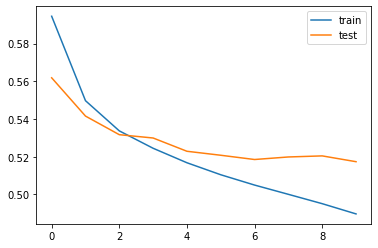

In [37]:
#plot loss and accuracy
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

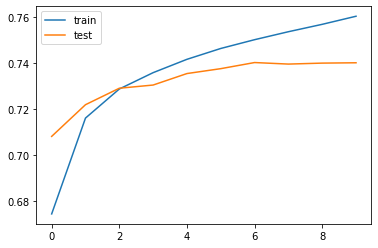

In [38]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [39]:
result = model.evaluate(test_data, X_test['label'])
print('Test set loss: ', result[0])
print('Test set accuracy: ', result[1])

6318/6318 [==============================] - 20s 3ms/step - loss: 0.5192 - accuracy: 0.7391
Test set loss:  0.5191577076911926
Test set accuracy:  0.7390863299369812


In [40]:
pred = model.predict(test_data)
pred = np.where(pred > 0.5, 1, 0)
pred = np.array(pred, dtype=int).tolist()
ytrue = X_test['label'].tolist()

In [41]:
confusion_matrix(ytrue, pred)

array([[79033, 22048],
       [30697, 70377]], dtype=int64)

<AxesSubplot:>

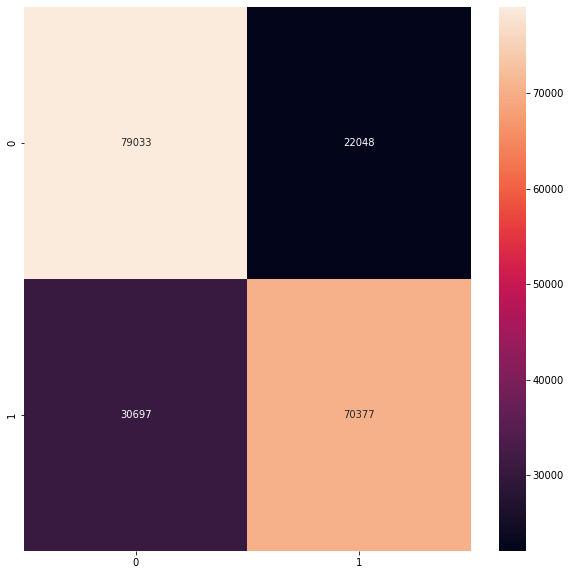

In [42]:
#plot the confusion matrix
import seaborn as sns
plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix(ytrue, pred), annot=True, fmt='d')

In [43]:
#classification report
print(classification_report(ytrue, pred))

              precision    recall  f1-score   support

           0       0.72      0.78      0.75    101081
           1       0.76      0.70      0.73    101074

    accuracy                           0.74    202155
   macro avg       0.74      0.74      0.74    202155
weighted avg       0.74      0.74      0.74    202155



### Logistic Regression with TFIDF Encoding

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix

In [45]:
tf_idf = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)
logit = LogisticRegression(C=1, n_jobs=-1, solver='lbfgs', random_state=17, verbose=1)
tfidf_logit_pipeline = Pipeline([('tf_idf', tf_idf), 
                                 ('logit', logit)])

In [46]:
tfidf_logit_pipeline.fit(X_train['comment'], X_train['label'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   10.5s finished


Pipeline(steps=[('tf_idf',
                 TfidfVectorizer(max_features=50000, min_df=2,
                                 ngram_range=(1, 2))),
                ('logit',
                 LogisticRegression(C=1, n_jobs=-1, random_state=17,
                                    verbose=1))])

In [47]:
#Prediction on Validation set
valid_pred = tfidf_logit_pipeline.predict(X_val['comment'])
accuracy_score(X_val['label'], valid_pred)

0.7205114887091588

In [48]:
#Prediction on Test set
test_pred = tfidf_logit_pipeline.predict(X_test['comment'])
accuracy_score(X_test['label'], test_pred)

0.7193984813633103

<AxesSubplot:>

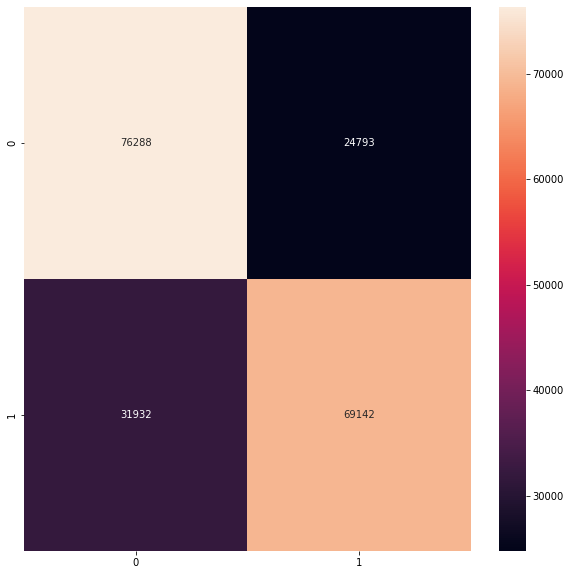

In [49]:
#plot the confusion matrix
import seaborn as sns
plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix(X_test['label'], test_pred), annot=True, fmt='d')

In [50]:
#classification report
print(classification_report(X_test['label'], test_pred))

              precision    recall  f1-score   support

           0       0.70      0.75      0.73    101081
           1       0.74      0.68      0.71    101074

    accuracy                           0.72    202155
   macro avg       0.72      0.72      0.72    202155
weighted avg       0.72      0.72      0.72    202155



### LSTM + FastText + Score column

In [51]:
input_layer = Input(shape=(CFG.MAX_LEN,))
embedding_layer = Embedding(input_dim=len(word_index)+1,
                            output_dim=CFG.EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=CFG.MAX_LEN,
                            trainable=False)(input_layer)
lstm_layer = LSTM(100,name='LSTM')(embedding_layer)
dropout_layer = Dropout(0.2)(lstm_layer)

#take score as input
input_layer2 = Input(shape=(1,),name='score_input')
dense_layer2_1 = Dense(units=256, activation='relu')(input_layer2)

#concatenate the two layers
concat_layer = Concatenate()([dropout_layer, dense_layer2_1])

dense_layer_1 = Dense(units=256, activation='relu')(concat_layer)
dense_layer_2 = Dense(units=128, activation='relu')(dense_layer_1)
output_layer = Dense(units=1, activation='sigmoid')(dense_layer_2)

model = Model(inputs=[input_layer,input_layer2], outputs=output_layer)
model.compile(loss=CFG.LOSS, optimizer=CFG.OPTIMIZER, metrics=['accuracy'])

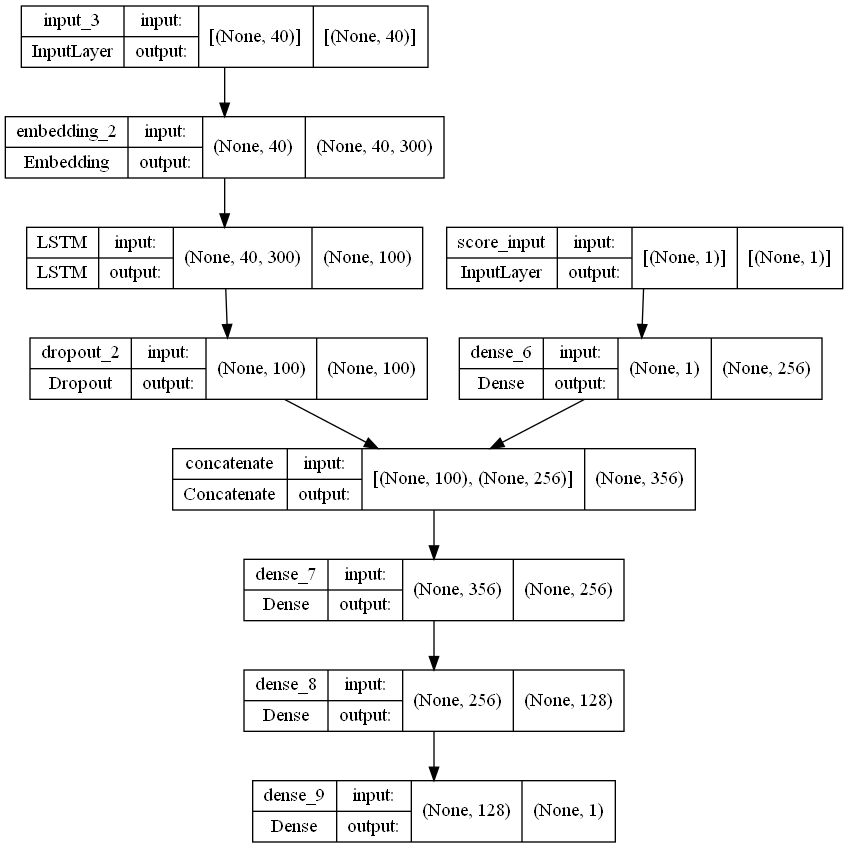

In [52]:
#plot the model
tf.keras.utils.plot_model(model, show_shapes=True)

In [53]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 40, 300)      41777700    ['input_3[0][0]']                
                                                                                                  
 LSTM (LSTM)                    (None, 100)          160400      ['embedding_2[0][0]']            
                                                                                                  
 score_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                            

In [54]:
try:
    history = model.fit([train_data,X_train['score']], X_train['label'], batch_size=CFG.BATCH_SIZE, epochs=CFG.EPOCHS, validation_data=([val_data,X_val['score']], X_val['label']))
except KeyboardInterrupt:
    print('\nTraining stopped by user.')

Epoch 1/10
711/711 [==============================] - 36s 48ms/step - loss: 0.5925 - accuracy: 0.6828 - val_loss: 0.5537 - val_accuracy: 0.7148
Epoch 2/10
711/711 [==============================] - 34s 48ms/step - loss: 0.5461 - accuracy: 0.7195 - val_loss: 0.5397 - val_accuracy: 0.7244
Epoch 3/10
711/711 [==============================] - 34s 48ms/step - loss: 0.5300 - accuracy: 0.7315 - val_loss: 0.5340 - val_accuracy: 0.7284
Epoch 4/10
711/711 [==============================] - 34s 48ms/step - loss: 0.5204 - accuracy: 0.7385 - val_loss: 0.5253 - val_accuracy: 0.7343
Epoch 5/10
711/711 [==============================] - 34s 48ms/step - loss: 0.5118 - accuracy: 0.7447 - val_loss: 0.5200 - val_accuracy: 0.7383
Epoch 6/10
711/711 [==============================] - 34s 48ms/step - loss: 0.5056 - accuracy: 0.7490 - val_loss: 0.5169 - val_accuracy: 0.7401
Epoch 7/10
711/711 [==============================] - 34s 48ms/step - loss: 0.4996 - accuracy: 0.7532 - val_loss: 0.5133 - val_accuracy:

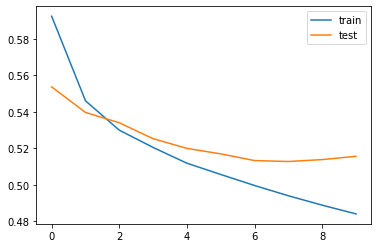

In [55]:
#plot loss and accuracy
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

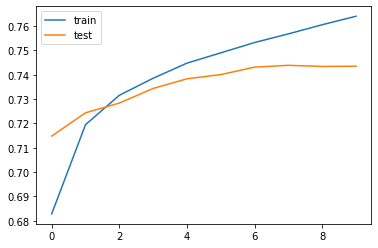

In [56]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [57]:
result = model.evaluate([test_data,X_test['score']], X_test['label'])
print('Test set loss: ', result[0])
print('Test set accuracy: ', result[1])

6318/6318 [==============================] - 22s 3ms/step - loss: 0.5152 - accuracy: 0.7428
Test set loss:  0.5151621699333191
Test set accuracy:  0.7427666783332825


In [58]:
pred = model.predict([test_data,X_test['score']])
pred = np.where(pred > 0.5, 1, 0)
pred = np.array(pred, dtype=int).tolist()
ytrue = X_test['label'].tolist()

In [59]:
confusion_matrix(ytrue, pred)

array([[75099, 25982],
       [26019, 75055]], dtype=int64)

<AxesSubplot:>

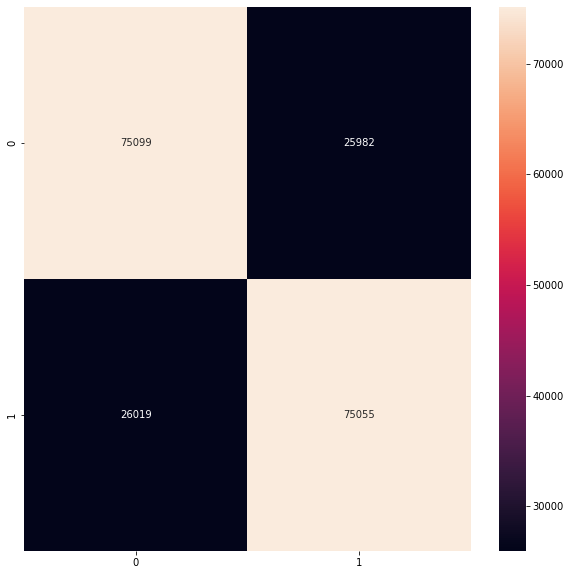

In [60]:
#plot the confusion matrix
import seaborn as sns
plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix(ytrue, pred), annot=True, fmt='d')

In [61]:
#classification report
print(classification_report(X_test['label'], test_pred))

              precision    recall  f1-score   support

           0       0.70      0.75      0.73    101081
           1       0.74      0.68      0.71    101074

    accuracy                           0.72    202155
   macro avg       0.72      0.72      0.72    202155
weighted avg       0.72      0.72      0.72    202155



### Result

In [65]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model Type","Accuracy", "F1 Score"]
x.add_row(["GLoVE + LSTM", 0.74, 0.75])
x.add_row(["FastText + LSTM",0.74, 0.75])
x.add_row(["Logistic Regression",0.74, 0.74])
x.add_row(["FastText + LSTM + Score Column",0.72, 0.73])
print(x)

+--------------------------------+----------+----------+
|           Model Type           | Accuracy | F1 Score |
+--------------------------------+----------+----------+
|          GLoVE + LSTM          |   0.74   |   0.75   |
|        FastText + LSTM         |   0.74   |   0.75   |
|      Logistic Regression       |   0.74   |   0.74   |
| FastText + LSTM + Score Column |   0.72   |   0.73   |
+--------------------------------+----------+----------+
